In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-06-03 01:40:04--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  10.8MB/s    in 31s     

2022-06-03 01:40:36 (10.2 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(10000,100000),cutout_ratio=[(0,1)]),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-06-03 01:40:37,635 - mmseg - INFO - Loaded 537 images
2022-06-03 01:40:41,517 - mmseg - INFO - Loaded 113 images
2022-06-03 01:40:41,521 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-06-03 01:40:42,060 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-06-03 01:40:42,068 - mmseg - INFO - Start running, host: root@b206be8c3340, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1
2022-06-03 01:40:42,070 - mmseg - INFO - Hooks will be exe

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 471s, ETA:     0s

2022-06-03 02:07:57,699 - mmseg - INFO - per class results:
2022-06-03 02:07:57,701 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.88 | 92.38 |
|  building  | 71.55 | 88.23 |
|  Boundary  | 42.16 | 55.06 |
+------------+-------+-------+
2022-06-03 02:07:57,703 - mmseg - INFO - Summary:
2022-06-03 02:07:57,705 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.15 | 66.86 | 78.56 |
+-------+-------+-------+
2022-06-03 02:07:57,708 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8615, mIoU: 0.6686, mAcc: 0.7856, IoU.background: 0.8688, IoU.building: 0.7155, IoU.Boundary: 0.4216, Acc.background: 0.9238, Acc.building: 0.8823, Acc.Boundary: 0.5506
2022-06-03 02:09:30,881 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 8:15:02, time: 5.638, data_time: 5.323, memory: 3323, decode.loss_dice: 0.2031, decode.loss_focal: 0.0458, decode.loss_lovasz: 0.3761, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-06-03 02:33:28,252 - mmseg - INFO - per class results:
2022-06-03 02:33:28,255 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.08 | 90.39 |
|  building  | 74.05 | 89.09 |
|  Boundary  | 47.79 | 67.69 |
+------------+-------+-------+
2022-06-03 02:33:28,256 - mmseg - INFO - Summary:
2022-06-03 02:33:28,259 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 86.9 | 69.64 | 82.39 |
+------+-------+-------+
2022-06-03 02:33:28,264 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8690, mIoU: 0.6964, mAcc: 0.8239, IoU.background: 0.8708, IoU.building: 0.7405, IoU.Boundary: 0.4779, Acc.background: 0.9039, Acc.building: 0.8909, Acc.Boundary: 0.6769
2022-06-03 02:35:44,964 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 7:49:12, time: 5.678, data_time: 5.364, memory: 3323, decode.loss_dice: 0.1794, decode.loss_focal: 0.0432, decode.loss_lovasz: 0.3441, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-06-03 03:00:20,837 - mmseg - INFO - per class results:
2022-06-03 03:00:20,839 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.48 | 92.57 |
|  building  | 75.66 | 87.87 |
|  Boundary  | 49.61 | 68.11 |
+------------+-------+-------+
2022-06-03 03:00:20,840 - mmseg - INFO - Summary:
2022-06-03 03:00:20,845 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.01 | 71.25 | 82.85 |
+-------+-------+-------+
2022-06-03 03:00:20,846 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8801, mIoU: 0.7125, mAcc: 0.8285, IoU.background: 0.8848, IoU.building: 0.7566, IoU.Boundary: 0.4961, Acc.background: 0.9257, Acc.building: 0.8787, Acc.Boundary: 0.6811
2022-06-03 03:02:24,785 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 7:25:27, time: 5.550, data_time: 5.236, memory: 3323, decode.loss_dice: 0.1716, decode.loss_focal: 0.0419, decode.loss_lovasz: 0.3385, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-06-03 03:25:45,448 - mmseg - INFO - per class results:
2022-06-03 03:25:45,451 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.31 | 94.51 |
|  building  | 76.47 | 90.07 |
|  Boundary  | 48.07 | 60.05 |
+------------+-------+-------+
2022-06-03 03:25:45,453 - mmseg - INFO - Summary:
2022-06-03 03:25:45,454 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.61 | 71.29 | 81.54 |
+-------+-------+-------+
2022-06-03 03:25:45,457 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8861, mIoU: 0.7129, mAcc: 0.8154, IoU.background: 0.8931, IoU.building: 0.7647, IoU.Boundary: 0.4807, Acc.background: 0.9451, Acc.building: 0.9007, Acc.Boundary: 0.6005
2022-06-03 03:27:35,652 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 6:54:31, time: 5.413, data_time: 5.100, memory: 3323, decode.loss_dice: 0.1563, decode.loss_focal: 0.0359, decode.loss_lovasz: 0.3121, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-03 03:52:15,634 - mmseg - INFO - per class results:
2022-06-03 03:52:15,636 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.87 | 90.48 |
|  building  | 76.31 | 91.15 |
|  Boundary  | 48.72 | 68.98 |
+------------+-------+-------+
2022-06-03 03:52:15,637 - mmseg - INFO - Summary:
2022-06-03 03:52:15,639 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.63 | 70.97 | 83.54 |
+-------+-------+-------+
2022-06-03 03:52:15,641 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8763, mIoU: 0.7097, mAcc: 0.8354, IoU.background: 0.8787, IoU.building: 0.7631, IoU.Boundary: 0.4872, Acc.background: 0.9048, Acc.building: 0.9115, Acc.Boundary: 0.6898
2022-06-03 03:53:57,242 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 6:29:18, time: 5.311, data_time: 4.996, memory: 3323, decode.loss_dice: 0.1471, decode.loss_focal: 0.0350, decode.loss_lovasz: 0.3003, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-03 04:18:22,414 - mmseg - INFO - per class results:
2022-06-03 04:18:22,415 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.47 | 94.18 |
|  building  | 77.35 |  87.2 |
|  Boundary  |  50.7 | 68.15 |
+------------+-------+-------+
2022-06-03 04:18:22,419 - mmseg - INFO - Summary:
2022-06-03 04:18:22,420 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.84 | 72.51 | 83.18 |
+-------+-------+-------+
2022-06-03 04:18:22,423 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8884, mIoU: 0.7251, mAcc: 0.8318, IoU.background: 0.8947, IoU.building: 0.7735, IoU.Boundary: 0.5070, Acc.background: 0.9418, Acc.building: 0.8720, Acc.Boundary: 0.6815
2022-06-03 04:20:04,632 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 6:03:09, time: 5.316, data_time: 5.003, memory: 3323, decode.loss_dice: 0.1428, decode.loss_focal: 0.0340, decode.loss_lovasz: 0.2931, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-03 04:43:34,416 - mmseg - INFO - per class results:
2022-06-03 04:43:34,418 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.05 | 94.86 |
|  building  |  78.1 | 88.72 |
|  Boundary  | 51.39 | 66.21 |
+------------+-------+-------+
2022-06-03 04:43:34,419 - mmseg - INFO - Summary:
2022-06-03 04:43:34,421 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.36 | 73.18 | 83.27 |
+-------+-------+-------+
2022-06-03 04:43:34,423 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8936, mIoU: 0.7318, mAcc: 0.8327, IoU.background: 0.9005, IoU.building: 0.7810, IoU.Boundary: 0.5139, Acc.background: 0.9486, Acc.building: 0.8872, Acc.Boundary: 0.6621
2022-06-03 04:45:22,937 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 5:35:32, time: 5.379, data_time: 5.063, memory: 3323, decode.loss_dice: 0.1448, decode.loss_focal: 0.0340, decode.loss_lovasz: 0.2942, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-06-03 05:09:41,036 - mmseg - INFO - per class results:
2022-06-03 05:09:41,037 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.05 | 93.75 |
|  building  | 78.41 | 89.97 |
|  Boundary  | 52.38 | 69.18 |
+------------+-------+-------+
2022-06-03 05:09:41,039 - mmseg - INFO - Summary:
2022-06-03 05:09:41,041 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.39 | 73.61 | 84.3 |
+-------+-------+------+
2022-06-03 05:09:41,045 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8939, mIoU: 0.7361, mAcc: 0.8430, IoU.background: 0.9005, IoU.building: 0.7841, IoU.Boundary: 0.5238, Acc.background: 0.9375, Acc.building: 0.8997, Acc.Boundary: 0.6918
2022-06-03 05:11:17,984 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 5:09:23, time: 5.266, data_time: 4.952, memory: 3323, decode.loss_dice: 0.1453, decode.loss_focal: 0.0372, decode.loss_lovasz: 0.2969, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-03 05:35:05,899 - mmseg - INFO - per class results:
2022-06-03 05:35:05,902 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.15 | 95.29 |
|  building  |  77.7 | 85.95 |
|  Boundary  | 52.15 | 69.08 |
+------------+-------+-------+
2022-06-03 05:35:05,904 - mmseg - INFO - Summary:
2022-06-03 05:35:05,907 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.36 | 73.33 | 83.44 |
+-------+-------+-------+
2022-06-03 05:35:05,910 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8936, mIoU: 0.7333, mAcc: 0.8344, IoU.background: 0.9015, IoU.building: 0.7770, IoU.Boundary: 0.5215, Acc.background: 0.9529, Acc.building: 0.8595, Acc.Boundary: 0.6908
2022-06-03 05:36:50,052 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 4:42:50, time: 5.362, data_time: 5.048, memory: 3323, decode.loss_dice: 0.1474, decode.loss_focal: 0.0363, decode.loss_lovasz: 0.2995, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-03 06:00:01,379 - mmseg - INFO - per class results:
2022-06-03 06:00:01,382 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.54 | 92.64 |
|  building  | 78.21 | 90.75 |
|  Boundary  | 50.96 | 69.34 |
+------------+-------+-------+
2022-06-03 06:00:01,383 - mmseg - INFO - Summary:
2022-06-03 06:00:01,385 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 88.92 | 72.9 | 84.25 |
+-------+------+-------+
2022-06-03 06:00:01,388 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8892, mIoU: 0.7290, mAcc: 0.8425, IoU.background: 0.8954, IoU.building: 0.7821, IoU.Boundary: 0.5096, Acc.background: 0.9264, Acc.building: 0.9075, Acc.Boundary: 0.6934
2022-06-03 06:02:02,776 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 4:16:10, time: 5.536, data_time: 5.221, memory: 3323, decode.loss_dice: 0.1485, decode.loss_focal: 0.0355, decode.loss_lovasz: 0.2955, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-03 06:26:08,732 - mmseg - INFO - per class results:
2022-06-03 06:26:08,735 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.31 | 94.47 |
|  building  |  78.7 | 89.31 |
|  Boundary  | 52.14 | 68.28 |
+------------+-------+-------+
2022-06-03 06:26:08,737 - mmseg - INFO - Summary:
2022-06-03 06:26:08,741 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.55 | 73.71 | 84.02 |
+-------+-------+-------+
2022-06-03 06:26:08,743 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8955, mIoU: 0.7371, mAcc: 0.8402, IoU.background: 0.9031, IoU.building: 0.7870, IoU.Boundary: 0.5214, Acc.background: 0.9447, Acc.building: 0.8931, Acc.Boundary: 0.6828
2022-06-03 06:27:42,394 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 3:50:07, time: 5.230, data_time: 4.916, memory: 3323, decode.loss_dice: 0.1423, decode.loss_focal: 0.0326, decode.loss_lovasz: 0.2825, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-03 06:52:19,737 - mmseg - INFO - per class results:
2022-06-03 06:52:19,739 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.7 | 95.08 |
|  building  |  78.8 | 87.99 |
|  Boundary  | 53.26 | 69.86 |
+------------+-------+-------+
2022-06-03 06:52:19,740 - mmseg - INFO - Summary:
2022-06-03 06:52:19,742 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.83 | 74.25 | 84.31 |
+-------+-------+-------+
2022-06-03 06:52:19,745 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8983, mIoU: 0.7425, mAcc: 0.8431, IoU.background: 0.9070, IoU.building: 0.7880, IoU.Boundary: 0.5326, Acc.background: 0.9508, Acc.building: 0.8799, Acc.Boundary: 0.6986
2022-06-03 06:54:21,667 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 3:24:47, time: 5.513, data_time: 5.201, memory: 3323, decode.loss_dice: 0.1336, decode.loss_focal: 0.0322, decode.loss_lovasz: 0.2801, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-06-03 07:18:12,605 - mmseg - INFO - per class results:
2022-06-03 07:18:12,607 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.42 | 94.53 |
|  building  | 78.55 | 87.62 |
|  Boundary  | 53.33 | 71.46 |
+------------+-------+-------+
2022-06-03 07:18:12,611 - mmseg - INFO - Summary:
2022-06-03 07:18:12,615 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.63 | 74.1 | 84.54 |
+-------+------+-------+
2022-06-03 07:18:12,617 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8963, mIoU: 0.7410, mAcc: 0.8454, IoU.background: 0.9042, IoU.building: 0.7855, IoU.Boundary: 0.5333, Acc.background: 0.9453, Acc.building: 0.8762, Acc.Boundary: 0.7146
2022-06-03 07:20:05,492 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 2:58:45, time: 5.423, data_time: 5.110, memory: 3323, decode.loss_dice: 0.1295, decode.loss_focal: 0.0314, decode.loss_lovasz: 0.2726, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-03 07:43:58,116 - mmseg - INFO - per class results:
2022-06-03 07:43:58,119 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.38 |  93.9 |
|  building  | 79.25 | 88.63 |
|  Boundary  | 53.74 | 73.04 |
+------------+-------+-------+
2022-06-03 07:43:58,120 - mmseg - INFO - Summary:
2022-06-03 07:43:58,124 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.7 | 74.46 | 85.19 |
+------+-------+-------+
2022-06-03 07:43:58,129 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8970, mIoU: 0.7446, mAcc: 0.8519, IoU.background: 0.9038, IoU.building: 0.7925, IoU.Boundary: 0.5374, Acc.background: 0.9390, Acc.building: 0.8863, Acc.Boundary: 0.7304
2022-06-03 07:46:00,405 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 2:32:51, time: 5.541, data_time: 5.229, memory: 3323, decode.loss_dice: 0.1326, decode.loss_focal: 0.0350, decode.loss_lovasz: 0.2750, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-03 08:09:03,464 - mmseg - INFO - per class results:
2022-06-03 08:09:03,468 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.61 | 94.64 |
|  building  | 79.06 | 88.58 |
|  Boundary  | 53.73 | 70.92 |
+------------+-------+-------+
2022-06-03 08:09:03,469 - mmseg - INFO - Summary:
2022-06-03 08:09:03,472 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.85 | 74.47 | 84.71 |
+-------+-------+-------+
2022-06-03 08:09:03,474 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8985, mIoU: 0.7447, mAcc: 0.8471, IoU.background: 0.9061, IoU.building: 0.7906, IoU.Boundary: 0.5373, Acc.background: 0.9464, Acc.building: 0.8858, Acc.Boundary: 0.7092
2022-06-03 08:10:46,635 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 2:06:34, time: 5.356, data_time: 5.043, memory: 3323, decode.loss_dice: 0.1319, decode.loss_focal: 0.0310, decode.loss_lovasz: 0.2751, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-06-03 08:33:52,684 - mmseg - INFO - per class results:
2022-06-03 08:33:52,686 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.79 | 94.85 |
|  building  | 79.08 | 87.77 |
|  Boundary  | 54.01 | 71.92 |
+------------+-------+-------+
2022-06-03 08:33:52,688 - mmseg - INFO - Summary:
2022-06-03 08:33:52,693 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.93 | 74.63 | 84.85 |
+-------+-------+-------+
2022-06-03 08:33:52,696 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8993, mIoU: 0.7463, mAcc: 0.8485, IoU.background: 0.9079, IoU.building: 0.7908, IoU.Boundary: 0.5401, Acc.background: 0.9485, Acc.building: 0.8777, Acc.Boundary: 0.7192
2022-06-03 08:35:34,060 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 1:40:29, time: 5.335, data_time: 5.020, memory: 3323, decode.loss_dice: 0.1271, decode.loss_focal: 0.0311, decode.loss_lovasz: 0.2709, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-06-03 09:00:29,000 - mmseg - INFO - per class results:
2022-06-03 09:00:29,003 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.85 | 94.86 |
|  building  |  79.2 | 87.98 |
|  Boundary  | 54.23 | 72.01 |
+------------+-------+-------+
2022-06-03 09:00:29,005 - mmseg - INFO - Summary:
2022-06-03 09:00:29,008 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.99 | 74.76 | 84.95 |
+-------+-------+-------+
2022-06-03 09:00:29,011 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8999, mIoU: 0.7476, mAcc: 0.8495, IoU.background: 0.9085, IoU.building: 0.7920, IoU.Boundary: 0.5423, Acc.background: 0.9486, Acc.building: 0.8798, Acc.Boundary: 0.7201
2022-06-03 09:02:19,571 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 1:14:53, time: 5.438, data_time: 5.124, memory: 3323, decode.loss_dice: 0.1271, decode.loss_focal: 0.0306, decode.loss_lovasz: 0.2692, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-06-03 09:26:09,961 - mmseg - INFO - per class results:
2022-06-03 09:26:09,963 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.01 | 95.69 |
|  building  | 79.35 | 88.13 |
|  Boundary  | 53.64 | 69.04 |
+------------+-------+-------+
2022-06-03 09:26:09,966 - mmseg - INFO - Summary:
2022-06-03 09:26:09,969 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.13 | 74.67 | 84.29 |
+-------+-------+-------+
2022-06-03 09:26:09,971 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9013, mIoU: 0.7467, mAcc: 0.8429, IoU.background: 0.9101, IoU.building: 0.7935, IoU.Boundary: 0.5364, Acc.background: 0.9569, Acc.building: 0.8813, Acc.Boundary: 0.6904
2022-06-03 09:27:36,711 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:49:00, time: 5.199, data_time: 4.884, memory: 3323, decode.loss_dice: 0.1232, decode.loss_focal: 0.0296, decode.loss_lovasz: 0.2595, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-06-03 09:51:48,814 - mmseg - INFO - per class results:
2022-06-03 09:51:48,816 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.56 | 93.94 |
|  building  | 79.26 |  88.2 |
|  Boundary  | 54.45 | 74.46 |
+------------+-------+-------+
2022-06-03 09:51:48,817 - mmseg - INFO - Summary:
2022-06-03 09:51:48,819 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.82 | 74.76 | 85.53 |
+-------+-------+-------+
2022-06-03 09:51:48,822 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8982, mIoU: 0.7476, mAcc: 0.8553, IoU.background: 0.9056, IoU.building: 0.7926, IoU.Boundary: 0.5445, Acc.background: 0.9394, Acc.building: 0.8820, Acc.Boundary: 0.7446
2022-06-03 09:53:38,072 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:23:13, time: 5.423, data_time: 5.111, memory: 3323, decode.loss_dice: 0.1290, decode.loss_focal: 0.0323, decode.loss_lovasz: 0.2737, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-06-03 10:17:45,882 - mmseg - INFO - per class results:
2022-06-03 10:17:45,884 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.78 | 94.71 |
|  building  | 79.31 |  88.0 |
|  Boundary  | 54.38 |  72.6 |
+------------+-------+-------+
2022-06-03 10:17:45,886 - mmseg - INFO - Summary:
2022-06-03 10:17:45,890 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.99 | 74.82 | 85.1 |
+-------+-------+------+
2022-06-03 10:17:45,892 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8999, mIoU: 0.7482, mAcc: 0.8510, IoU.background: 0.9078, IoU.building: 0.7931, IoU.Boundary: 0.5438, Acc.background: 0.9471, Acc.building: 0.8800, Acc.Boundary: 0.7260


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


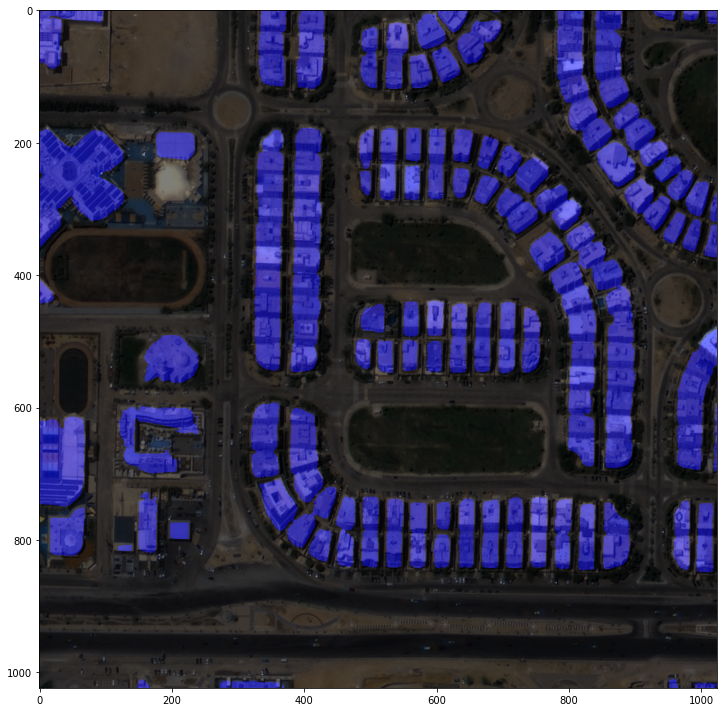

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


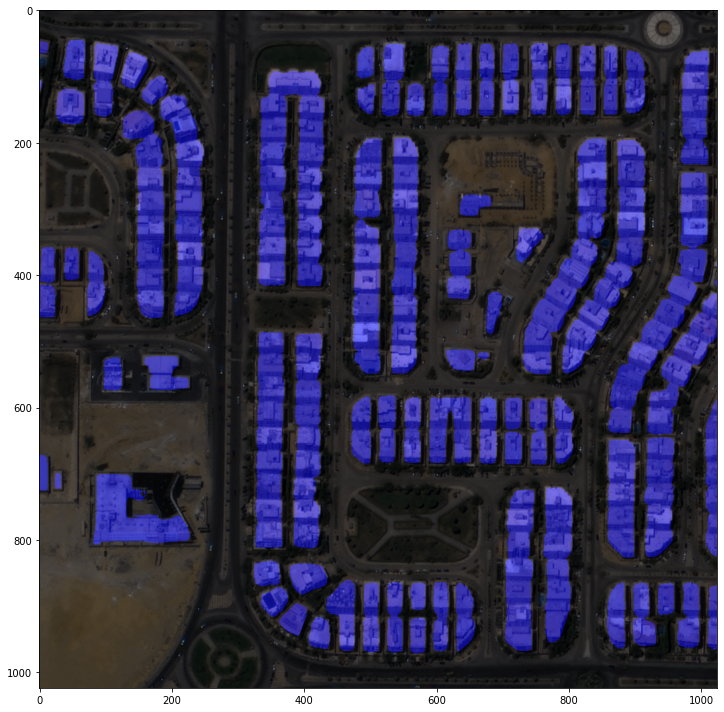

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


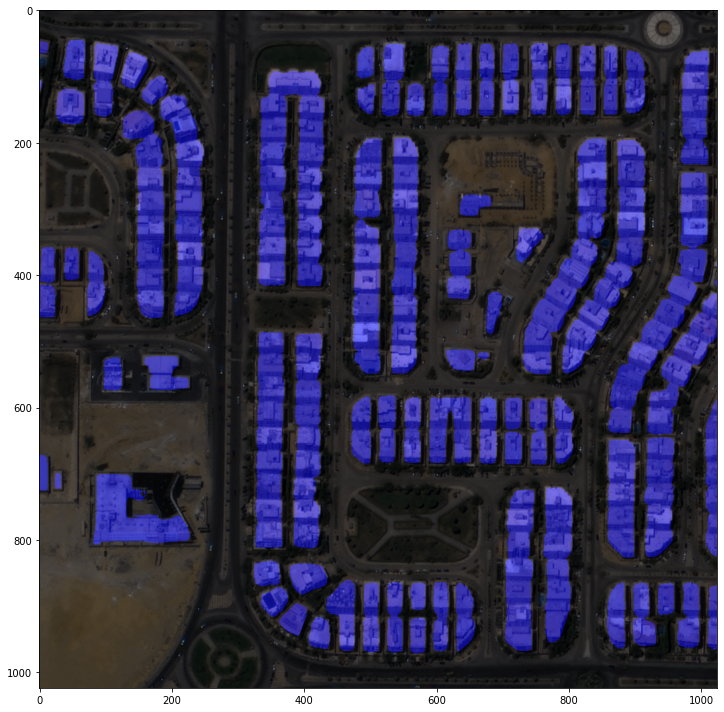

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


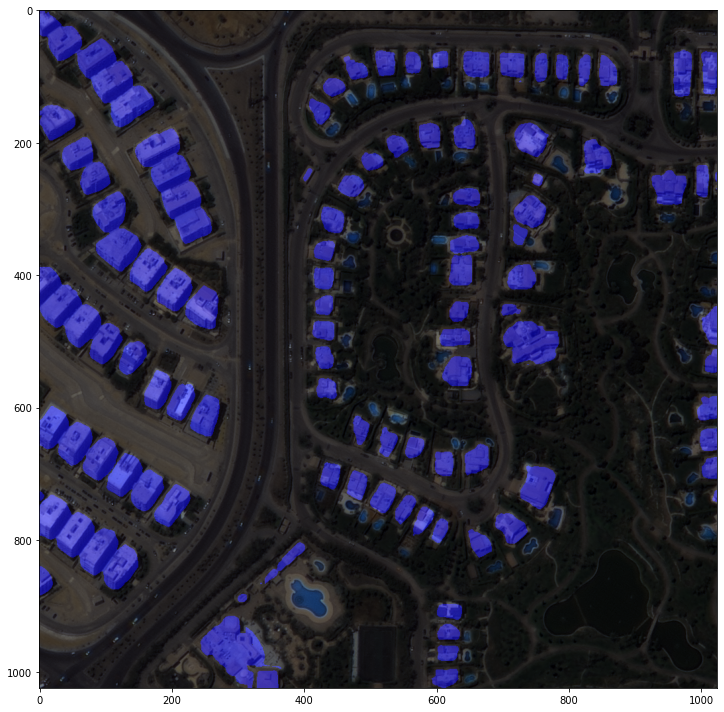

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


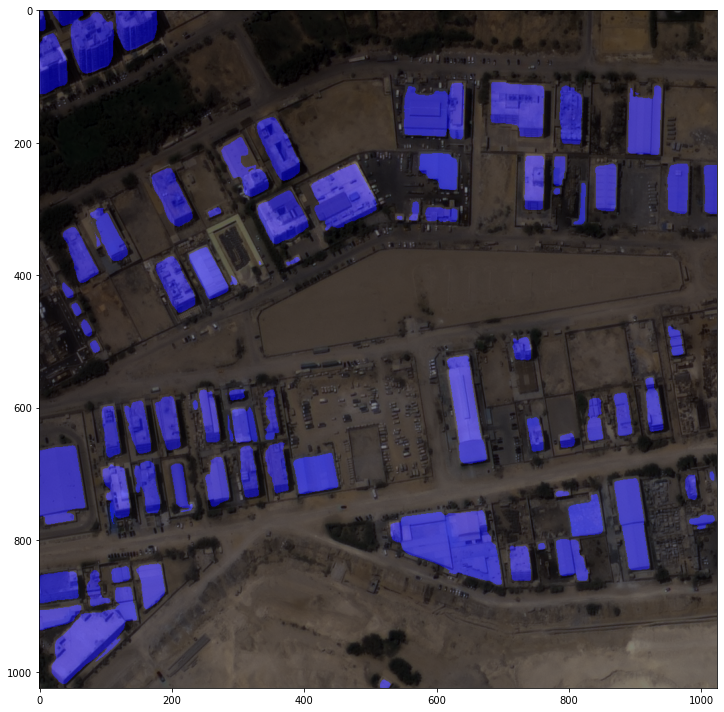

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


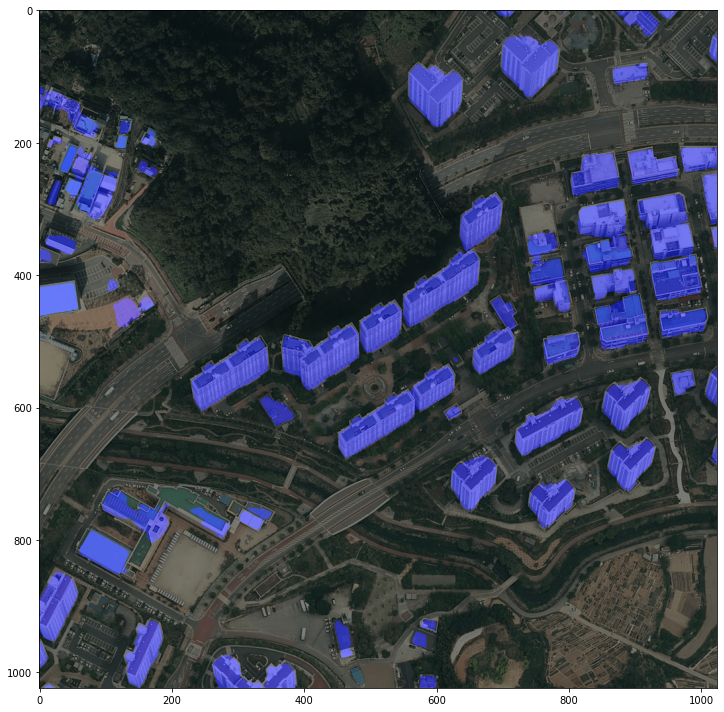

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


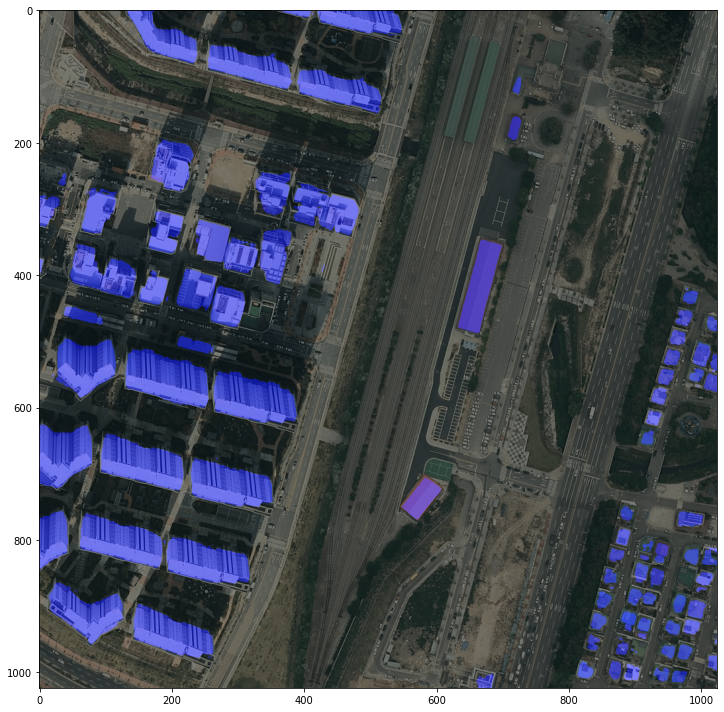

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


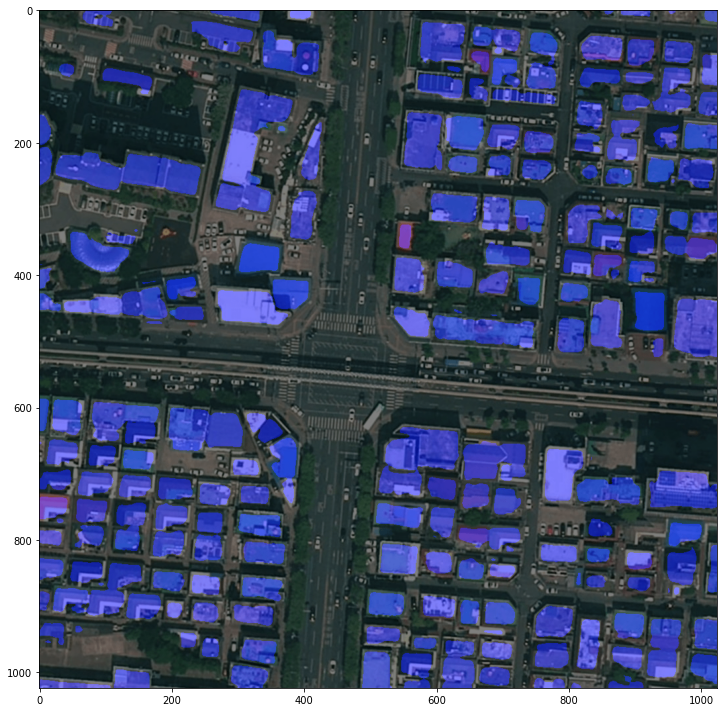

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_10000_100000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)